In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from zipfile import ZipFile
from tqdm import tqdm
import shapely
from shapely import MultiPolygon, Polygon, Point
import rasterio
import rasterio.warp
from rasterio import plot, CRS
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set
from dacite import from_dict
from dataclasses import dataclass
from abc import ABC
import math
import shutil
from pathlib import Path
import datetime
from shapely.ops import unary_union

from aimlsse_api.data.metar import *

In [2]:
target_states = ['California', 'Montana', 'Washington', 'Florida']

In [3]:
make_distribution_uniform = False
remove_ambiguous_cloud_cover = True

In [4]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

In [5]:
data_dir = 'data'
dataset_dir = os.path.join(data_dir, 'dataset')
if remove_ambiguous_cloud_cover:
    dataset_dir += '_unambiguous_cc'
if make_distribution_uniform:
    dataset_dir += '_sampled'
state_dirs = pd.DataFrame(pd.Series(target_states, name='state'))
state_dirs['target']    = state_dirs['state'].apply(lambda state: os.path.join(data_dir, 'queries', state))
state_dirs['features']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'features'))
state_dirs['preprocessing']  = state_dirs['target'].apply(lambda target_dir: os.path.join(target_dir, 'preprocessing'))
state_dirs.set_index('state', inplace=True)
for dir in [data_dir, dataset_dir] + state_dirs['features'].to_list() \
        + state_dirs['preprocessing'].to_list():
    os.makedirs(dir, exist_ok=True)

In [6]:
state_dirs

,target,features,preprocessing
state,,,
California,data\queries\California,data\queries\California\features,data\queries\California\preprocessing
Montana,data\queries\Montana,data\queries\Montana\features,data\queries\Montana\preprocessing
Washington,data\queries\Washington,data\queries\Washington\features,data\queries\Washington\preprocessing
Florida,data\queries\Florida,data\queries\Florida\features,data\queries\Florida\preprocessing


In [7]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [8]:
sentinel_products_metadata = pd.concat([
    pd.read_csv(os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv'), index_col=0) for preprocessing_dir in state_dirs['preprocessing']
])
date_columns = ['beginposition', 'endposition', 'generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)
print(f'Found metadata for {sentinel_products_metadata.shape[0]} sentinel products')

Found metadata for 13203 sentinel products


In [9]:
sentinel_products_metadata.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid'],
      dtype='object')

In [10]:
station_metadata = []
for state in target_states:
    tmp_station_metadata = pd.read_csv(os.path.join(state_dirs.loc[state, 'preprocessing'], 'station_metadata.csv'), index_col='id')
    tmp_station_metadata['state'] = state
    station_metadata += [tmp_station_metadata]
station_metadata = pd.concat(station_metadata)
station_metadata.drop(columns=['index_right'], inplace=True)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, geometry=station_metadata['geometry'], crs='EPSG:4326')
print(f'Found metadata for {station_metadata.shape[0]} stations')

Found metadata for 10826 stations


In [11]:
station_metadata

,geometry,name,plot_name,network,latitude,longitude,elevation,ISO_A3_EH,country,CONTINENT,distance_to_region,state
id,,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.120800,USA,United States of America,North America,0.0,California
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.855200,USA,United States of America,North America,0.0,California
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.152000,USA,United States of America,North America,0.0,California
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.000000,USA,United States of America,North America,0.0,California
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.000000,USA,United States of America,North America,0.0,California
...,...,...,...,...,...,...,...,...,...,...,...,...
92826,POINT (-81.31000 25.89000),92826,NaN,USCRN,25.89000,-81.31000,4.000000,USA,United States of America,North America,0.0,Florida
92827,POINT (-81.36000 27.15000),92827,NaN,USCRN,27.15000,-81.36000,150.000000,USA,United States of America,North America,0.0,Florida
92821,POINT (-80.69000 28.61000),92821,NaN,USCRN,28.61000,-80.69000,3.000000,USA,United States of America,North America,0.0,Florida


In [12]:
all_metars = pd.concat([
    pd.read_json(os.path.join(preprocessing_dir, 'all_metars.json'), orient='table') for preprocessing_dir in state_dirs['preprocessing']
]).reset_index(drop=True)
all_metars.drop_duplicates(subset=['station', 'datetime', 'product_id'])
all_metars['datetime'] = pd.to_datetime(all_metars['datetime'], unit='ms', utc=True)
print(f'Found {all_metars.shape[0]} METARs')

Found 27024 METARs


In [13]:
pd.set_option('display.max_colwidth', None)
all_metars['sky_conditions [M]']

0                                                                   [{'cloud': None, 'cover': 'SCT', 'height': 1127.7599639117}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
1        [{'cloud': None, 'cover': 'FEW', 'height': 182.8799941478}, {'cloud': None, 'cover': 'SCT', 'height': 1676.3999463552}, {'cloud': None, 'cover': 'OVC', 'height': 2133.5999317248}]
2                                                                     [{'cloud': None, 'cover': 'SCT', 'height': 274.3199912218}, {'cloud': None, 'cover': 'OVC', 'height': 487.6799843942}]
3                                                                                                                               [{'cloud': None, 'cover': 'OVC', 'height': 1402.0799551334}]
4                                                                                                                               [{'cloud': None, 'cover': 'OVC', 'height': 1341.1199570842}]
                                                       

In [14]:
metar_property_labels = list(filter(lambda x: x not in ['station', 'datetime', 'product_id'], all_metars.columns))
metar_properties = [MetarProperty.from_string(label) for label in metar_property_labels]
print([str(prop) for prop in metar_properties])

['temperature [C]', 'current_weather', 'recent_weather', 'sky_conditions [M]', 'metar_code']


In [15]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

{'cloud': None, 'cover': 'OVC', 'height': 792.4799746406}


In [16]:
all_metars = MetarPandas.format_dataframe(all_metars, metar_properties)

In [17]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

DataSkyConditions(cover='OVC', height=792.4799746406, cloud=None)


In [18]:
metars_per_product = all_metars.groupby(['product_id'])
print(f'METARs are available for {len(metars_per_product.groups)} products')

METARs are available for 6522 products


In [19]:
product_files: Dict[str, List[str]] = {state: os.listdir(data['features']) for state, data in state_dirs.iterrows()}
print(f'Found {sum([len(products) for products in product_files.values()])} products in total')
print({state: len(products) for state, products in product_files.items()})

Found 5015 products in total
{'California': 1606, 'Montana': 1298, 'Washington': 1185, 'Florida': 926}


In [20]:
products_per_state: Dict[str, List[str]] = {}
for state in target_states:
    features_dir = state_dirs.loc[state, 'features']
    print(features_dir)
    for file in tqdm(list(filter(lambda x: x.endswith('.zip'), product_files[state]))):
        filepath = os.path.join(features_dir, file)
        with ZipFile(filepath) as zip_file:
            zip_file.extractall(features_dir)
        os.remove(filepath)
    local_products: List[str] = os.listdir(features_dir)
    print(f'Found {len(local_products)} products for {state}')
    products_per_state[state] = local_products
all_products = [product for state in target_states for product in products_per_state[state]]
print(f'Found {len(all_products)} products in total')

data\queries\California\features


0it [00:00, ?it/s]


Found 1606 products for California
data\queries\Montana\features


0it [00:00, ?it/s]


Found 1298 products for Montana
data\queries\Washington\features


0it [00:00, ?it/s]


Found 1185 products for Washington
data\queries\Florida\features


0it [00:00, ?it/s]

Found 926 products for Florida
Found 5015 products in total


Text(0.5, 0, 'cloud cover %')

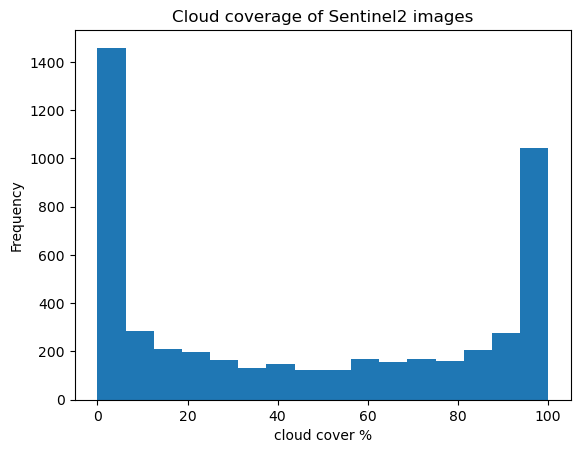

In [21]:
ax: plt.Axes = sentinel_products_metadata.loc[all_products]['cloudcoverpercentage'].plot.hist(bins=16)
ax.set_title('Cloud coverage of Sentinel2 images')
ax.set_xlabel('cloud cover %')

In [22]:
all_metars['timedelta'] = all_metars.apply(lambda row: row['datetime'].to_numpy() - sentinel_products_metadata.loc[row['product_id']]['beginposition'].to_numpy(), axis=1)
all_metars['timedelta [minutes]'] = all_metars['timedelta'].map(lambda x: x.total_seconds() / 60.0)

In [23]:
available_stations_in_products = []
for state, products in products_per_state.items():
    for product in products:
        product_dir = os.path.join(state_dirs.loc[state, 'features'], product)
        product_bands = os.listdir(product_dir)
        stations = set()
        for band in product_bands:
            band_dir = os.path.join(product_dir, band)
            stations = stations.union(set([Path(file).stem for file in os.listdir(band_dir)]))
        for station in stations:
            available_stations_in_products += [{'product_id': product, 'station': station}]
available_stations_in_products = pd.DataFrame(available_stations_in_products)

In [24]:
available_metars = all_metars[(all_metars['product_id'].isin(all_products)) \
                              & (all_metars['sky_conditions [M]'].map(lambda x: len(x) > 0))].copy()
keys = list(available_stations_in_products.columns.values)
i1 = available_metars.set_index(keys).index
i2 = available_stations_in_products.set_index(keys).index
available_metars = available_metars[i1.isin(i2)].copy()
print(f'{available_metars.shape[0]} of {all_metars.shape[0]} METARs are available and satisfy requirements'
      f' [{float(available_metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

20309 of 27024 METARs are available and satisfy requirements [75.2 %]


In [25]:
def get_newest_label(data:pd.DataFrame):
    return data.loc[data['timedelta [minutes]'].abs().idxmin()]

In [26]:
metars = available_metars.groupby(['product_id', 'station'], group_keys=True).apply(lambda x: get_newest_label(x))
print(f'{metars.shape[0]} of {all_metars.shape[0]} METARs remain for the dataset when only taking the nearest timestamp'
      f' [{float(metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

11030 of 27024 METARs remain for the dataset when only taking the nearest timestamp [40.8 %]


In [27]:
cloud_cover_strength = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [28]:
metars['max cloud cover'] = metars['sky_conditions [M]'].apply(get_max_cloud_cover)
metars = metars[metars['max cloud cover'].isin(cloud_covers_order)]

In [29]:
metars['cloud cover'] = metars['sky_conditions [M]'].apply(lambda x: [sky.cover for sky in x])
metars['cloud cover']

product_id                            station
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9  COF        [CLR]
                                      MLB        [CLR]
                                      TIX        [CLR]
                                      TTS        [CLR]
                                      XMR        [CLR]
                                                 ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d  LCQ        [OVC]
ffef155f-3c61-4e07-a2c4-39a61331917d  DLO        [OVC]
fff87278-9cf2-452f-b630-8d8f5bfa60f1  BTM        [CLR]
                                      DLN        [CLR]
                                      RVF        [CLR]
Name: cloud cover, Length: 10996, dtype: object

In [30]:
tmp = metars['cloud cover'].apply(lambda x: (len(x) == 1) or any([cc == 'OVC' for cc in x]))
ambiguous_cc_metars = metars[~tmp]
true_cc_metars = metars[tmp]
print(f'{ambiguous_cc_metars.shape[0]} of {metars.shape[0]} have ambiguous cloud coverage'
      f'[{ambiguous_cc_metars.shape[0] / metars.shape[0] * 100.0:.1f} %]')
print(true_cc_metars['cloud cover'].head())
print(ambiguous_cc_metars['cloud cover'].head())


1268 of 10996 have ambiguous cloud coverage[11.5 %]
product_id                            station
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9  COF        [CLR]
                                      MLB        [CLR]
                                      TIX        [CLR]
                                      TTS        [CLR]
                                      XMR        [CLR]
Name: cloud cover, dtype: object
product_id                            station
001be058-4542-4cbd-b469-6677cc086ff3  LCQ                  [BKN, BKN]
002276a1-d3f5-494d-93c8-92e199d63501  APC                  [SCT, BKN]
                                      DWA             [SCT, SCT, BKN]
                                      STS                  [FEW, SCT]
                                      SUU        [SCT, BKN, BKN, BKN]
Name: cloud cover, dtype: object


In [34]:
if remove_ambiguous_cloud_cover:
    metars = true_cc_metars.copy()

<Axes: title={'center': 'Ambiguous cloud cover'}>

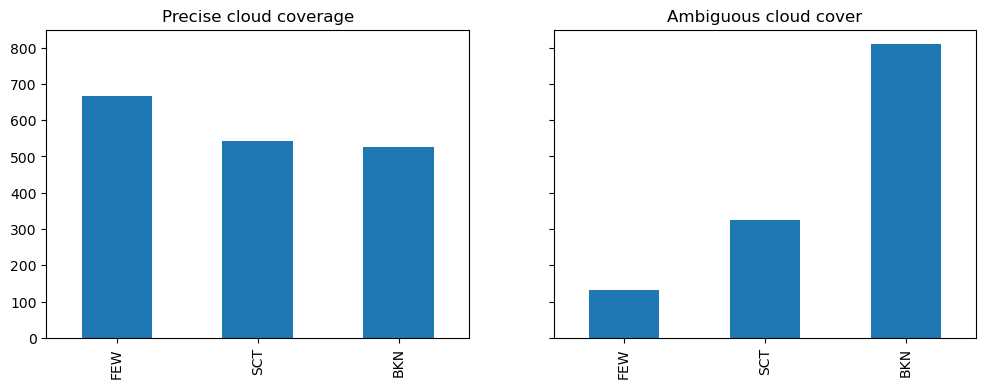

In [35]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, sharey=True)

true_cc_metars_ctr = dict(Counter(true_cc_metars['max cloud cover']))
for cc in cloud_covers_order:
    if cc not in true_cc_metars_ctr:
        true_cc_metars_ctr[cc] = 0
pd.Series(true_cc_metars_ctr).loc[['FEW', 'SCT', 'BKN']].plot.bar(ax=axs[0], title='Precise cloud coverage')

ambiguous_cc_metars_ctr = dict(Counter(ambiguous_cc_metars['max cloud cover']))
for cc in cloud_covers_order:
    if cc not in ambiguous_cc_metars_ctr:
        ambiguous_cc_metars_ctr[cc] = 0
pd.Series(ambiguous_cc_metars_ctr).loc[['FEW', 'SCT', 'BKN']].plot.bar(ax=axs[1], title='Ambiguous cloud cover')

In [36]:
cc_counts = metars.groupby('max cloud cover').count()['station'].loc[cloud_covers_order]
cc_counts

max cloud cover
CLR    5330
FEW     668
SCT     544
BKN     526
OVC    2660
Name: station, dtype: int64

<Axes: title={'center': 'Maximum cloud coverage'}, xlabel='max cloud cover'>

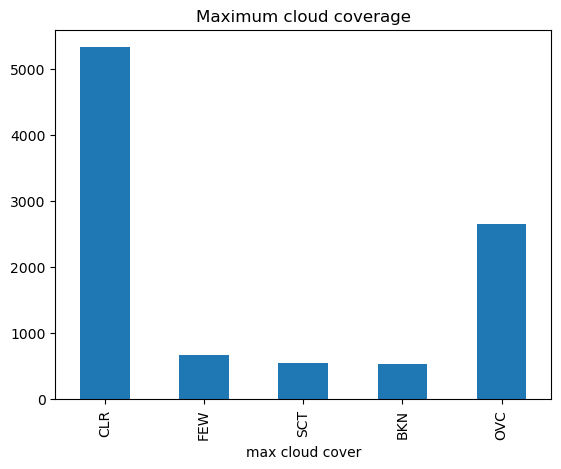

In [37]:
cc_min_count = cc_counts.min()

if make_distribution_uniform:
    sampled_metars = []
    for cc in cloud_covers_order:
        sampled_metars += [metars[metars['max cloud cover'] == cc].sample(cc_min_count)]
    metars = pd.concat(sampled_metars)
metars.groupby('max cloud cover').count()['station'].loc[cloud_covers_order].plot.bar(title='Maximum cloud coverage')

In [38]:
remaining_stations = metars['station'].drop_duplicates().to_numpy()
print(f'{len(remaining_stations)} stations remain')

280 stations remain


In [39]:
clouds = metars['sky_conditions [M]'].apply(lambda skys: [sky.cloud for sky in skys]).to_list()
clouds = pd.Series([item for sublist in clouds for item in sublist])
clouds

0        None
1        None
2        None
3        None
4        None
         ... 
11429    None
11430    None
11431    None
11432    None
11433    None
Length: 11434, dtype: object

In [40]:
Counter(clouds)

Counter({None: 11431, 'CB': 3})

Text(0.5, 0, 'time offset in minutes')

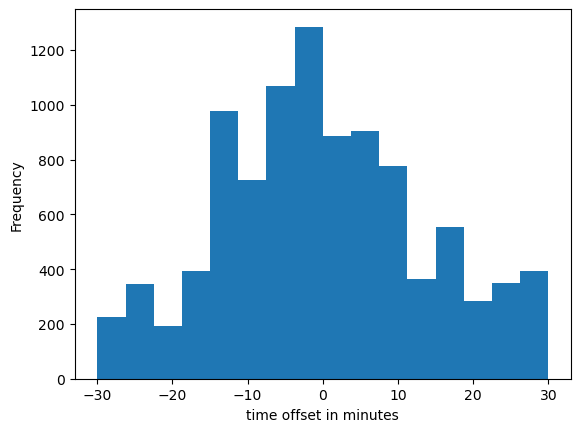

In [41]:
ax: plt.Axes = metars['timedelta [minutes]'].plot.hist(bins=16)
ax.set_xlabel('time offset in minutes')

In [42]:
station_radius_of_influence = 8000.0 # meters

In [43]:
polygons: List[Polygon] = []
for geometry in usa_states.loc[target_states].geometry:
    if isinstance(geometry, MultiPolygon):
        polygons += list(geometry.geoms)
    elif isinstance(geometry, Polygon):
        polygons += [geometry]

<class 'shapely.geometry.multipolygon.MultiPolygon'>


<Axes: >

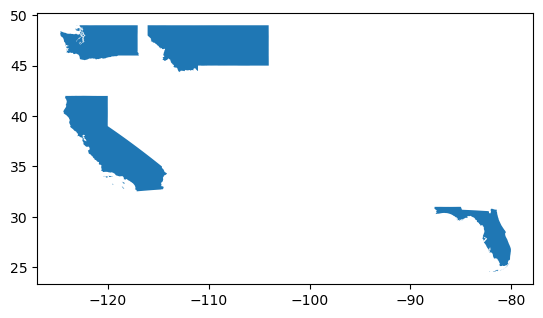

In [44]:
area_of_interest: MultiPolygon = unary_union(polygons)
print(type(area_of_interest))
gpd.GeoSeries(area_of_interest).plot()

In [45]:
def plot_state(ax:plt.Axes, state:str, color:str):
    gpd.GeoSeries(usa_states.loc[state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

In [46]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [47]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [48]:
remaining_stations_metadata = station_metadata.loc[remaining_stations]

In [49]:
remaining_stations_metadata['geometry'] = remaining_stations_metadata['geometry'].apply(
    lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
)

In [50]:
intersections: gpd.GeoDataFrame = remaining_stations_metadata[['geometry']].sjoin(remaining_stations_metadata[['geometry']], predicate="intersects")

In [51]:
intersections = intersections[intersections['index_right'] != intersections.index]

In [52]:
intersections = intersections.sample(frac=1, random_state=1)

In [53]:
intersections.head()

,geometry,index_right
id,,
OKB,"POLYGON ((-117.27222 33.15464, -117.27222 33.28537, -117.42774 33.28537, -117.42774 33.15464, -117.27222 33.15464))",CRQ
CQT,"POLYGON ((-118.21305 33.95848, -118.21305 34.08860, -118.36932 34.08860, -118.36932 33.95848, -118.21305 33.95848))",LAX
SAN,"POLYGON ((-117.10714 32.66856, -117.10714 32.79929, -117.26180 32.79929, -117.26180 32.66856, -117.10714 32.66856))",NZY
CCB,"POLYGON ((-117.60882 34.04626, -117.60882 34.17695, -117.76594 34.17695, -117.76594 34.04626, -117.60882 34.04626))",ONT
SMO,"POLYGON ((-118.36901 33.95602, -118.36901 34.08599, -118.52511 34.08599, -118.52511 33.95602, -118.36901 33.95602))",HHR


In [54]:
intersections_groups = intersections[['index_right']].groupby('index_right').groups
print(intersections_groups)

{'1YT': ['YKM'], '9L2': ['EDW'], 'AJO': ['CNO'], 'BAB': ['MYV'], 'BCT': ['PMP'], 'BFI': ['SEA', 'RNT'], 'BOW': ['GIF'], 'BUR': ['VNY', 'WHP'], 'CCB': ['POC', 'ONT'], 'CEW': ['EGI'], 'CNO': ['AJO', 'POC', 'ONT'], 'COF': ['MLB'], 'CQT': ['LAX', 'HHR', 'SMO'], 'CRG': ['NRB', 'NIP'], 'CRQ': ['OKB'], 'DAB': ['OMN'], 'DTS': ['VPS'], 'DVO': ['O69'], 'EDW': ['9L2'], 'EGI': ['CEW'], 'EPH': ['MWH'], 'EYW': ['NQX'], 'FLL': ['HWO'], 'FMY': ['RSW'], 'GEG': ['SKA'], 'GFA': ['GTF'], 'GIF': ['BOW'], 'GRF': ['TCM'], 'GTF': ['GFA'], 'HAF': ['SFO'], 'HEG': ['NIP', 'VQQ'], 'HHR': ['SMO', 'CQT', 'TOA', 'LAX'], 'HRT': ['VPS'], 'HWD': ['OAK'], 'HWO': ['OPF', 'FLL'], 'IPL': ['NJK'], 'ISM': ['MCO'], 'L18': ['NFG'], 'LAX': ['CQT', 'SMO', 'HHR'], 'LNA': ['PBI'], 'LPC': ['VBG'], 'MCC': ['MHR'], 'MCE': ['MER'], 'MCO': ['ISM', 'ORL'], 'MER': ['MCE'], 'MHR': ['MCC'], 'MIA': ['OPF'], 'MLB': ['COF'], 'MWH': ['EPH'], 'MYF': ['NKX', 'SAN', 'NZY'], 'MYV': ['BAB'], 'NFG': ['NXF', 'OKB', 'L18'], 'NIP': ['CRG', 'HEG'], 'NJK

In [55]:
import networkx
import networkx.convert
graph = networkx.convert.from_dict_of_lists(intersections_groups)

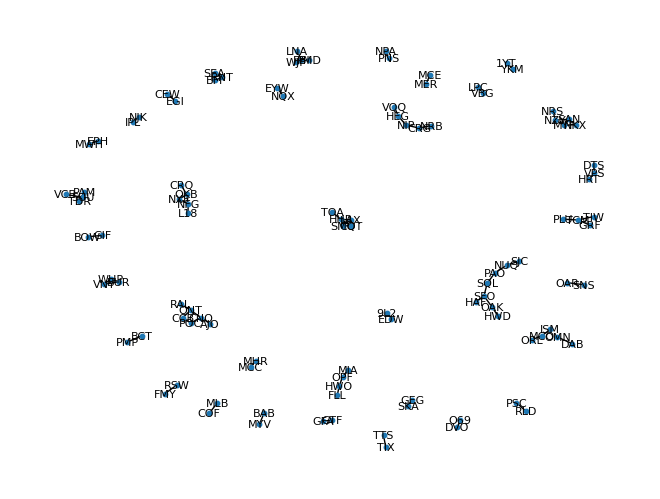

In [56]:
networkx.draw(graph, with_labels=True, font_size=8, node_size=10)

In [57]:
clusters = list(networkx.connected_components(graph))
print(clusters)
num_clusters = len(clusters)

[{'YKM', '1YT'}, {'9L2', 'EDW'}, {'CNO', 'RAL', 'CCB', 'AJO', 'POC', 'ONT'}, {'BAB', 'MYV'}, {'BCT', 'PMP'}, {'RNT', 'SEA', 'BFI'}, {'GIF', 'BOW'}, {'WHP', 'BUR', 'VNY'}, {'EGI', 'CEW'}, {'COF', 'MLB'}, {'SMO', 'CQT', 'HHR', 'TOA', 'LAX'}, {'NRB', 'HEG', 'NIP', 'CRG', 'VQQ'}, {'NFG', 'CRQ', 'OKB', 'NXF', 'L18'}, {'OMN', 'DAB'}, {'VPS', 'HRT', 'DTS'}, {'O69', 'DVO'}, {'EPH', 'MWH'}, {'NQX', 'EYW'}, {'FLL', 'MIA', 'HWO', 'OPF'}, {'RSW', 'FMY'}, {'GEG', 'SKA'}, {'GFA', 'GTF'}, {'TIW', 'PLU', 'GRF', 'TCM'}, {'SFO', 'SQL', 'HAF', 'NUQ', 'PAO', 'OAK', 'SJC', 'HWD'}, {'NJK', 'IPL'}, {'ORL', 'ISM', 'MCO'}, {'PBI', 'LNA'}, {'VBG', 'LPC'}, {'MHR', 'MCC'}, {'MER', 'MCE'}, {'NZY', 'MYF', 'NKX', 'NRS', 'SAN'}, {'NPA', 'PNS'}, {'OAR', 'SNS'}, {'PAM', 'TDR'}, {'WJF', 'PMD'}, {'RLD', 'PSC'}, {'SUU', 'VCB'}, {'TIX', 'TTS'}]


In [58]:
def get_mapping_from_clusters(clusters:List[Set[str]]):
    mapping = {}
    current_cluster = 0
    for cluster in clusters:
        for node in cluster:
            mapping[node] = current_cluster
        current_cluster += 1
    return mapping

node_to_cluster_mapping = get_mapping_from_clusters(clusters)
print(node_to_cluster_mapping)

{'YKM': 0, '1YT': 0, '9L2': 1, 'EDW': 1, 'CNO': 2, 'RAL': 2, 'CCB': 2, 'AJO': 2, 'POC': 2, 'ONT': 2, 'BAB': 3, 'MYV': 3, 'BCT': 4, 'PMP': 4, 'RNT': 5, 'SEA': 5, 'BFI': 5, 'GIF': 6, 'BOW': 6, 'WHP': 7, 'BUR': 7, 'VNY': 7, 'EGI': 8, 'CEW': 8, 'COF': 9, 'MLB': 9, 'SMO': 10, 'CQT': 10, 'HHR': 10, 'TOA': 10, 'LAX': 10, 'NRB': 11, 'HEG': 11, 'NIP': 11, 'CRG': 11, 'VQQ': 11, 'NFG': 12, 'CRQ': 12, 'OKB': 12, 'NXF': 12, 'L18': 12, 'OMN': 13, 'DAB': 13, 'VPS': 14, 'HRT': 14, 'DTS': 14, 'O69': 15, 'DVO': 15, 'EPH': 16, 'MWH': 16, 'NQX': 17, 'EYW': 17, 'FLL': 18, 'MIA': 18, 'HWO': 18, 'OPF': 18, 'RSW': 19, 'FMY': 19, 'GEG': 20, 'SKA': 20, 'GFA': 21, 'GTF': 21, 'TIW': 22, 'PLU': 22, 'GRF': 22, 'TCM': 22, 'SFO': 23, 'SQL': 23, 'HAF': 23, 'NUQ': 23, 'PAO': 23, 'OAK': 23, 'SJC': 23, 'HWD': 23, 'NJK': 24, 'IPL': 24, 'ORL': 25, 'ISM': 25, 'MCO': 25, 'PBI': 26, 'LNA': 26, 'VBG': 27, 'LPC': 27, 'MHR': 28, 'MCC': 28, 'MER': 29, 'MCE': 29, 'NZY': 30, 'MYF': 30, 'NKX': 30, 'NRS': 30, 'SAN': 30, 'NPA': 31, 'P

In [59]:
clusted_stations = intersections.index.to_list()
print(clusted_stations)
remaining_stations_metadata['cluster'] = remaining_stations_metadata['name'].apply(
    lambda x: node_to_cluster_mapping[x] if x in clusted_stations else -1
)

['OKB', 'CQT', 'SAN', 'CCB', 'SMO', 'YKM', 'HEG', 'VPS', 'SJC', 'GTF', 'RAL', 'POC', 'NFG', 'LPC', 'PSC', 'SEA', 'HRT', 'NPA', 'TIW', 'NRB', 'TCM', 'MCO', 'CRG', 'CEW', 'HEG', 'LAX', 'CQT', 'HHR', 'PAO', 'MYV', 'SMO', 'IPL', 'LNA', 'NZY', 'SAN', 'OPF', 'PAO', 'OMN', 'SQL', 'VNY', 'SFO', 'PMD', 'NXF', 'GIF', '9L2', 'MCE', 'CCB', 'NKX', 'BOW', 'SQL', 'RLD', 'SFO', 'SAN', 'HHR', 'CQT', 'MCO', 'CNO', 'WJF', 'GEG', 'CNO', 'RNT', 'VPS', 'CNO', 'MWH', 'DAB', 'TTS', 'EDW', 'O69', 'COF', 'PMP', 'OKB', 'NUQ', 'OAR', 'RSW', 'HAF', 'NXF', 'NZY', 'ISM', 'NIP', 'VBG', 'TCM', 'EPH', 'HHR', 'TOA', 'MER', 'LAX', 'SEA', 'PBI', 'ONT', 'BUR', 'VNY', 'MYF', 'SUU', 'HWO', 'NIP', '1YT', 'FMY', 'GRF', 'VQQ', 'AJO', 'BCT', 'L18', 'DTS', 'BFI', 'SMO', 'BFI', 'NUQ', 'WHP', 'MYF', 'GFA', 'WHP', 'NQX', 'ORL', 'FLL', 'OAK', 'TDR', 'MYF', 'TIX', 'POC', 'LAX', 'ONT', 'SNS', 'OAK', 'BAB', 'SKA', 'PLU', 'VCB', 'RNT', 'CRQ', 'HWO', 'MLB', 'SFO', 'PAM', 'NFG', 'NFG', 'DVO', 'TCM', 'CRG', 'NRS', 'HWD', 'OPF', 'EGI', 'NJK'

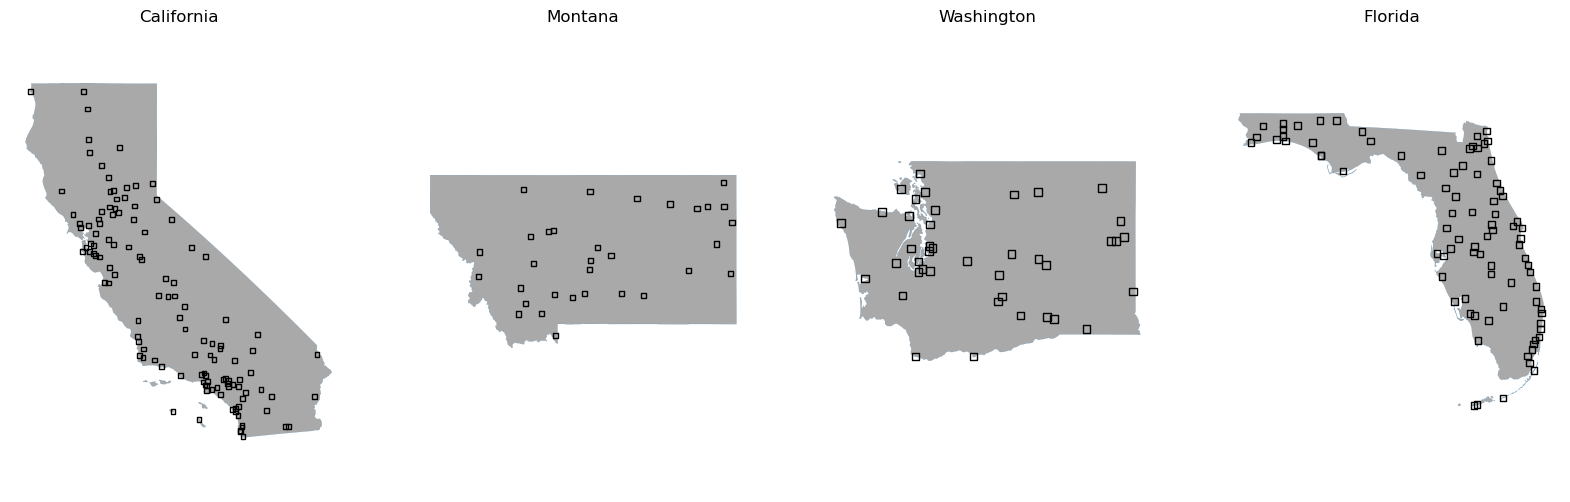

In [60]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[remaining_stations_metadata['state'] == state].plot(
        ax=ax, facecolor='none', edgecolor='black', legend=True
    )

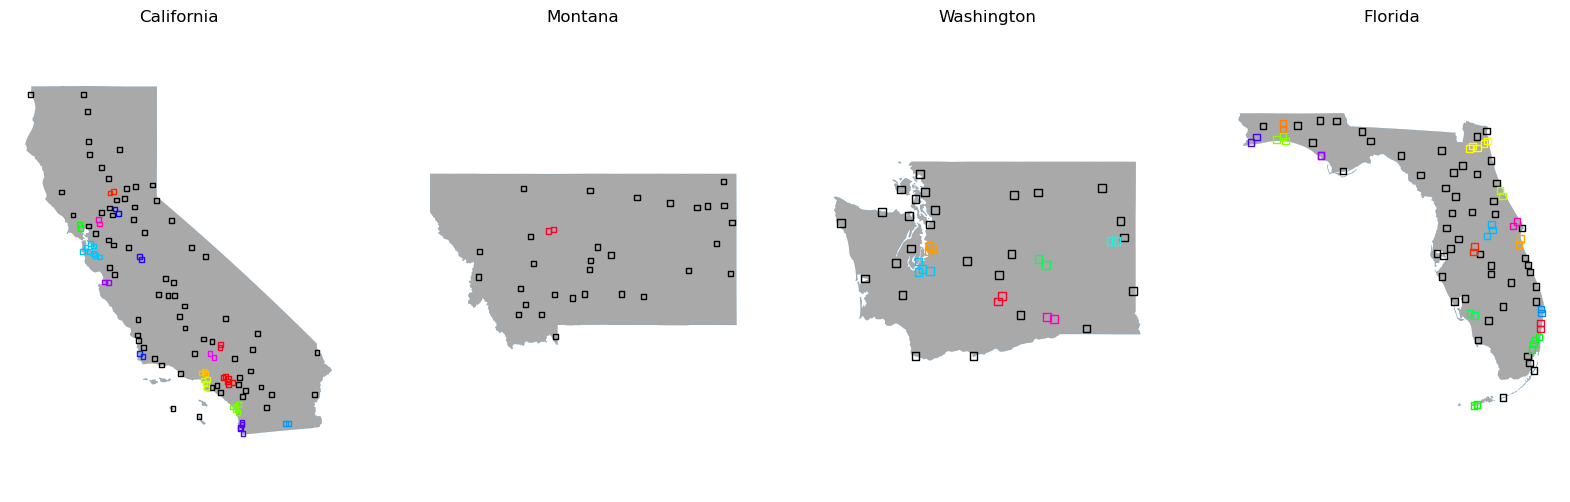

In [61]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] == -1)].plot(
        ax=ax, facecolor='none', edgecolor='black', legend=False
    )
    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] != -1)].plot(
        column='cluster', ax=ax, facecolor='none', cmap='gist_rainbow', legend=False
    )

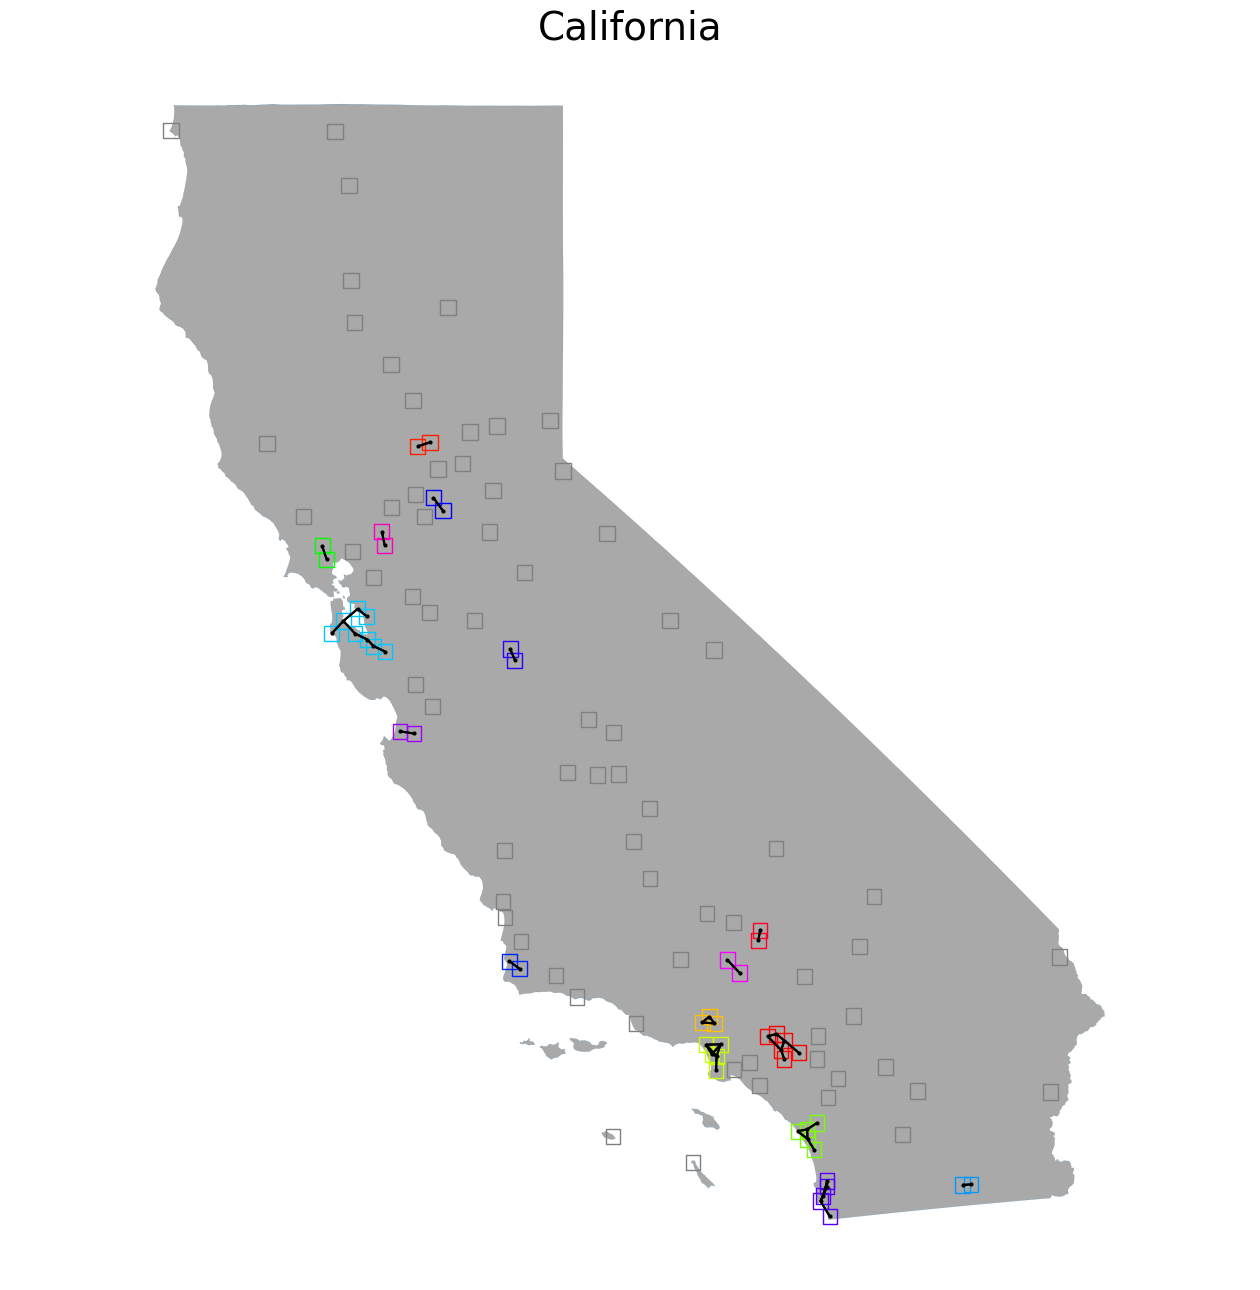

In [62]:
import warnings

fig, ax = plt.subplots(figsize=(16, 16))
if 'California' in target_states:
    state = 'California'
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state, fontsize=28)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] == -1)].plot(
        ax=ax, facecolor='none', edgecolor='gray', legend=False
    )

    remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] != -1)].plot(
        column='cluster', ax=ax, facecolor='none', cmap='gist_rainbow', legend=False
    )

    for name, group in remaining_stations_metadata[(remaining_stations_metadata['state'] == state) & (remaining_stations_metadata['cluster'] != -1)].groupby('cluster'):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            centroid_data = group.centroid
        current_intersections: Dict[str, pd.Index] = dict(filter(lambda x: x[0] in group.index.to_list(), intersections_groups.items()))
        lines = []
        for station in group.index:
            for other_station in current_intersections[station]:
                lines += [shapely.LineString([centroid_data.loc[station], centroid_data.loc[other_station]])]
                # if station in current_intersections[other_station]:
                #     current_intersections[other_station] = list(current_intersections[other_station]).remove(station)
                # if current_intersections[other_station] is None:
                #     current_intersections[other_station] = []
        gpd.GeoSeries(lines, crs=centroid_data.crs).plot(ax=ax, color='black')
        centroid_data.plot(ax=ax, color='black', markersize=4)
        

In [63]:
cloud_covers = pd.DataFrame(metars['sky_conditions [M]'])
cloud_covers['cloud cover'] = cloud_covers['sky_conditions [M]'].apply(lambda sky_conditions: [cond.cover for cond in sky_conditions])
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                        
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MLB                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TIX                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TTS                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     XMR                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
...                                                                                                           ...   
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ      [DataSkyConditions(cover='OVC', height=182.8799941478, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO      [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     DLN                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     RVF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   

                                             cloud cover  
product_id                           station              
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF           [CLR]  
                                     MLB           [CLR]  
                                     TIX           [CLR]  
                                     TTS           [CLR]  
                                     XMR           [CLR]  
...                                                  ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ           [OVC]  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]  
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM           [CLR]  
                                     DLN           [CLR]  
                                     RVF           [CLR]  

[9728 rows x 2 columns]

In [64]:
cloud_covers_flat = [item for sublist in cloud_covers['cloud cover'] for item in sublist]
print(cloud_covers_flat)

['CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'CLR', 'CLR', 'CLR', 'OVC', 'BKN', 'OVC', 'FEW', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'FEW', 'FEW', 'CLR', 'CLR', 'CLR', 'BKN', 'BKN', 'SCT', 'BKN', 'OVC', 'CLR', 'CLR', 'SCT', 'BKN', 'OVC', 'OVC', 'BKN', 'OVC', 'OVC', 'FEW', 'SCT', 'OVC', 'OVC', 'CLR', 'CLR', 'FEW', 'FEW', 'OVC', 'BKN', 'CLR', 'CLR', 'OVC', 'FEW', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'CLR', 'BKN', 'CLR', 'FEW', 'FEW', 'CLR', 'OVC', 'OVC', 'FEW', 'CLR', 'FEW', 'CLR', 'CLR', 'SCT', 'BKN', 'OVC', 'CLR', 'CLR', 'CLR', 'BKN', 'BKN', 'OVC', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'SCT', 'OVC', 'BKN', 'OVC', 'SCT', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'OVC', 'BKN', 'OVC', 'CLR', 'OVC', 'SCT', 'OVC', 'SCT', 'OVC', 'OVC', 'CLR', 'SCT', 'CLR', 'FEW', 'CLR', 'CLR', 'CLR', 'FEW', 'CLR', 'CLR', 'CLR', 'CLR', 'CLR', 'FEW', 'BKN', 'OVC', 'BKN', 'OVC', 'CLR', 'FEW'

<Axes: >

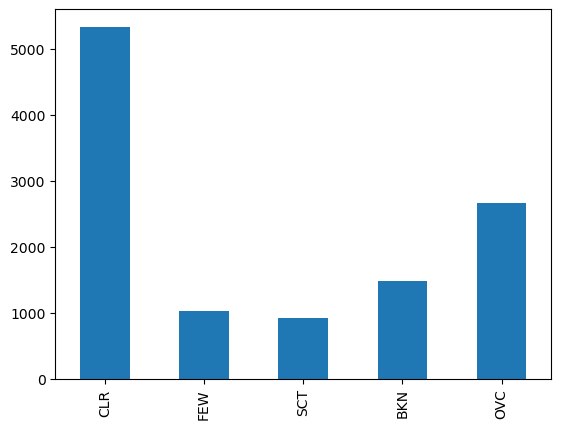

In [65]:
pd.Series(dict(Counter(cloud_covers_flat))).loc[cloud_covers_order].plot(kind='bar')

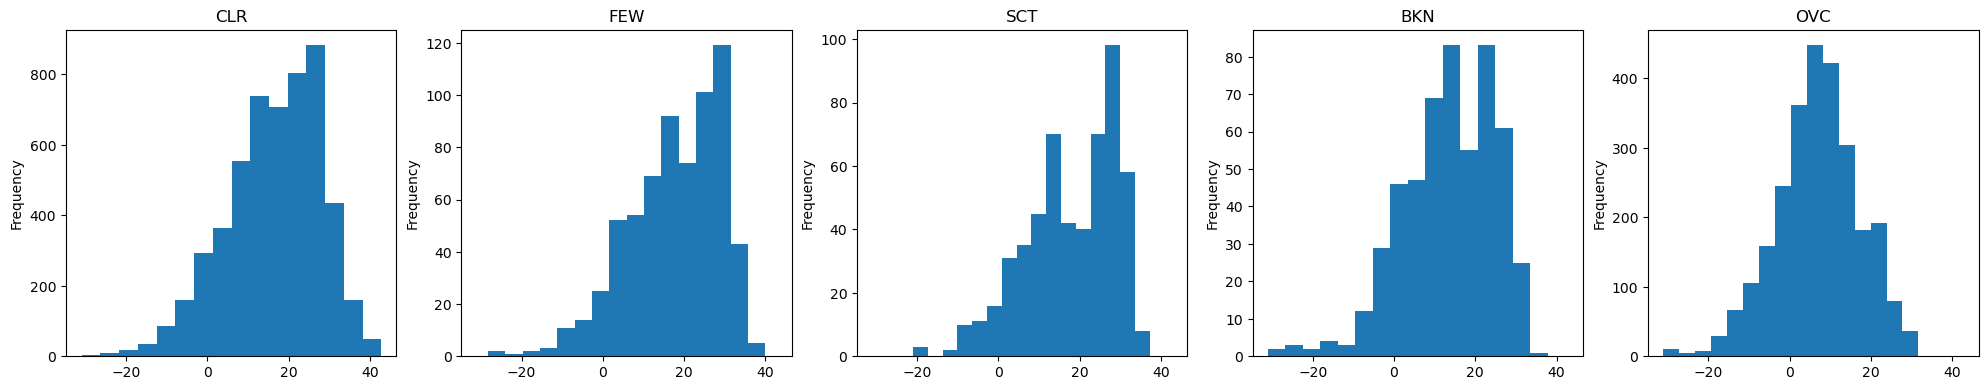

In [66]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(cloud_covers_order), sharex=True)
fig.tight_layout(pad=1.6)
for i, cc in enumerate(cloud_covers_order):
    ax: plt.Axes = axs[i]
    ax.set_title(cc)
    metars[metars['max cloud cover'] == cc]['temperature [C]'].plot.hist(ax=ax, bins=16)

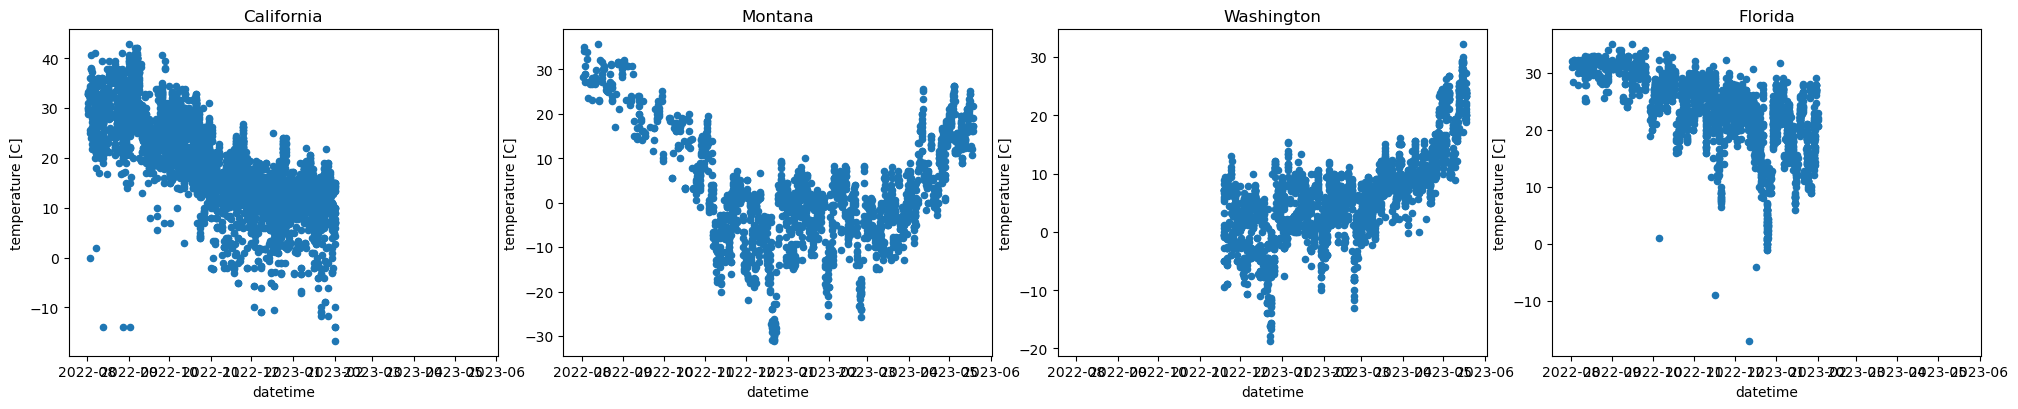

In [67]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states), sharex=True)
fig.tight_layout(pad=1.6)
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_title(state)
    local_stations = station_metadata[station_metadata['state'] == state]
    metars[metars['station'].isin(local_stations.index)].plot.scatter(ax=ax, x='datetime', y='temperature [C]')

In [68]:
metars.columns

Index(['station', 'datetime', 'temperature [C]', 'current_weather',
       'recent_weather', 'sky_conditions [M]', 'metar_code', 'product_id',
       'timedelta', 'timedelta [minutes]', 'max cloud cover', 'cloud cover'],
      dtype='object')

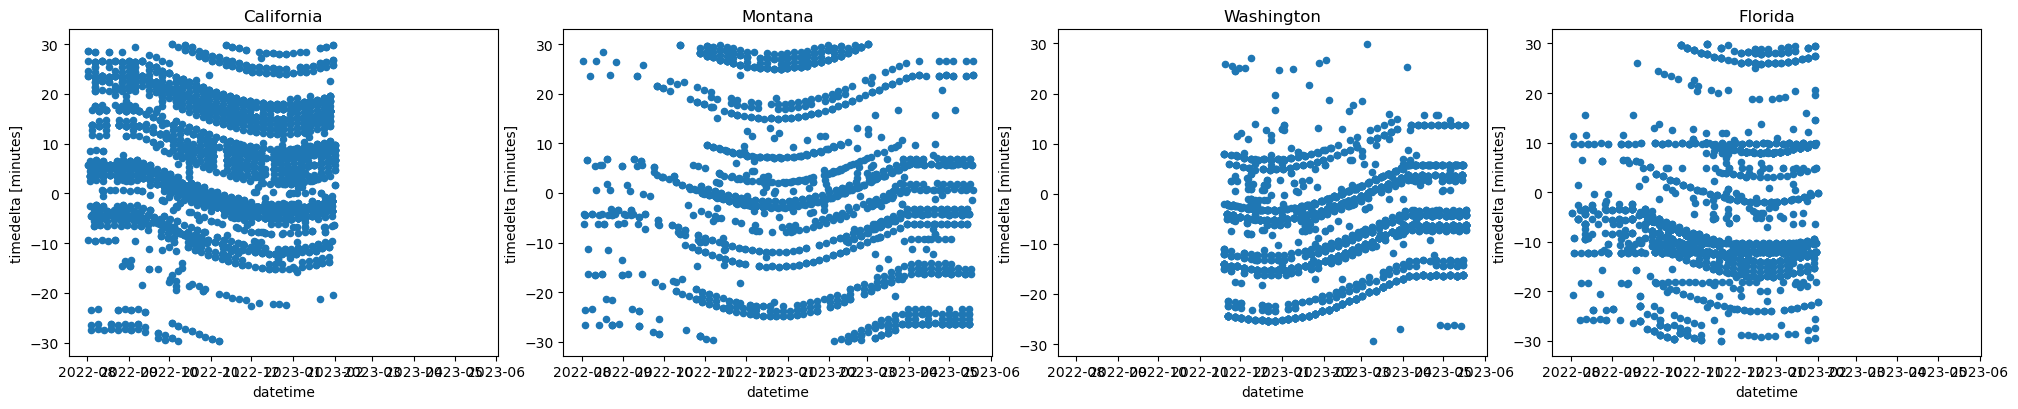

In [69]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states), sharex=True)
fig.tight_layout(pad=1.6)
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_title(state)
    local_stations = station_metadata[station_metadata['state'] == state]
    metars[metars['station'].isin(local_stations.index)].plot.scatter(ax=ax, x='datetime', y='timedelta [minutes]')

                      datetime  CLR  FEW  SCT  BKN  OVC
0    2022-08-01 15:55:00+00:00  2.0  NaN  NaN  NaN  NaN
1    2022-08-01 18:20:00+00:00  1.0  NaN  NaN  NaN  NaN
2    2022-08-01 18:35:00+00:00  2.0  NaN  NaN  NaN  NaN
3    2022-08-01 18:53:00+00:00  NaN  1.0  1.0  NaN  NaN
4    2022-08-01 18:54:00+00:00  1.0  NaN  NaN  NaN  NaN
...                        ...  ...  ...  ...  ...  ...
3227 2023-05-17 18:55:00+00:00  4.0  1.0  NaN  NaN  1.0
3228 2023-05-17 18:56:00+00:00  3.0  NaN  NaN  NaN  NaN
3229 2023-05-18 18:30:00+00:00  1.0  NaN  NaN  NaN  NaN
3230 2023-05-18 18:53:00+00:00  3.0  NaN  NaN  NaN  NaN
3231 2023-05-18 18:56:00+00:00  1.0  NaN  NaN  NaN  NaN

[3232 rows x 6 columns]


c:\Users\erikw\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1259: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


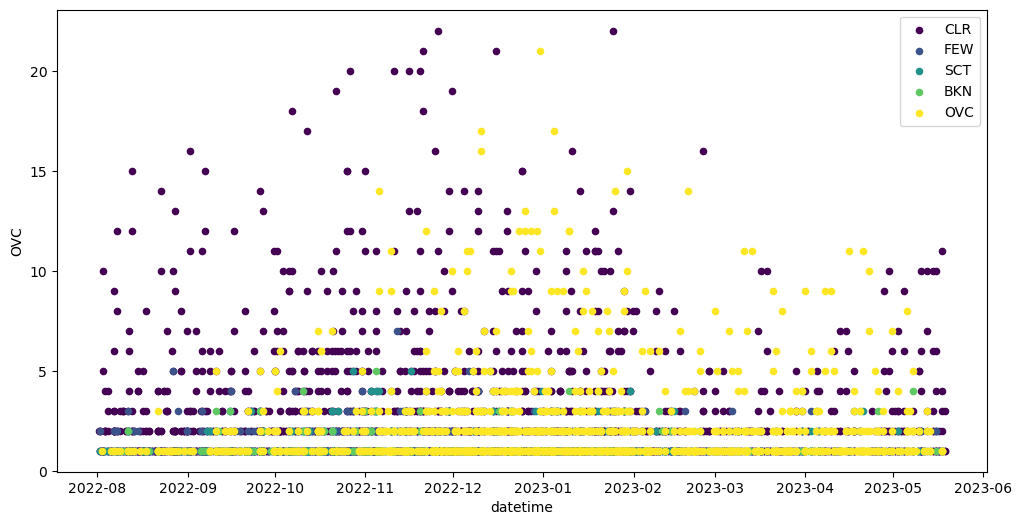

In [70]:
fig,ax = plt.subplots(figsize=(12,6))

data = []
for cc in cloud_covers_order:
    metars_selection = metars[metars['max cloud cover']==cc]
    data += [metars_selection[['datetime', 'max cloud cover']].groupby('datetime').value_counts().reset_index('max cloud cover', drop=True)]
data = pd.DataFrame(data).T
data.columns = cloud_covers_order
data.reset_index(inplace=True)
print(data)

colors = cm.viridis(np.linspace(0, 1, len(cloud_covers_order)))
for cc, color in zip(cloud_covers_order, colors):
    data.plot.scatter(ax=ax, x='datetime', y=cc, c=color)

ax.legend(cloud_covers_order, loc='best')

In [71]:
cloud_covers['cloud cover max'] = cloud_covers['sky_conditions [M]'].map(get_max_cloud_cover)
cloud_covers['cloud cover max']

product_id                            station
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9  COF        CLR
                                      MLB        CLR
                                      TIX        CLR
                                      TTS        CLR
                                      XMR        CLR
                                                ... 
ffd75b3f-eebb-4200-9577-d705bcdcf84d  LCQ        OVC
ffef155f-3c61-4e07-a2c4-39a61331917d  DLO        OVC
fff87278-9cf2-452f-b630-8d8f5bfa60f1  BTM        CLR
                                      DLN        CLR
                                      RVF        CLR
Name: cloud cover max, Length: 9728, dtype: object

In [72]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))

CLR    5330
FEW     668
OVC    2660
BKN     526
SCT     544
dtype: int64

In [73]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order]

CLR    5330
FEW     668
SCT     544
BKN     526
OVC    2660
dtype: int64

In [74]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order].sum()

9728

<Axes: title={'center': 'Maximum cloud coverage by weather stations'}>

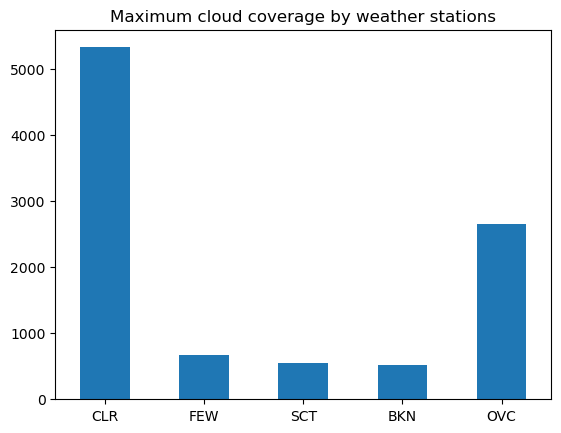

In [75]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order].plot(kind='bar', title='Maximum cloud coverage by weather stations', rot=0)

In [76]:
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                        
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MLB                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TIX                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TTS                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     XMR                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
...                                                                                                           ...   
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ      [DataSkyConditions(cover='OVC', height=182.8799941478, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO      [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     DLN                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     RVF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   

                                             cloud cover cloud cover max  
product_id                           station                              
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF           [CLR]             CLR  
                                     MLB           [CLR]             CLR  
                                     TIX           [CLR]             CLR  
                                     TTS           [CLR]             CLR  
                                     XMR           [CLR]             CLR  
...                                                  ...             ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ           [OVC]             OVC  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]             OVC  
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM           [CLR]             CLR  
                                     DLN           [CLR]             CLR  
                                     RVF           [CLR]             CLR  

[9728 rows x 3 columns]

In [77]:
cloud_covers

sky_conditions [M]  \
product_id                           station                                                                        
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     MLB                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TIX                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     TTS                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     XMR                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
...                                                                                                           ...   
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ      [DataSkyConditions(cover='OVC', height=182.8799941478, cloud=None)]   
ffef155f-3c61-4e07-a2c4-39a61331917d DLO      [DataSkyConditions(cover='OVC', height=152.3999951232, cloud=None)]   
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     DLN                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   
                                     RVF                [DataSkyConditions(cover='CLR', height=None, cloud=None)]   

                                             cloud cover cloud cover max  
product_id                           station                              
0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9 COF           [CLR]             CLR  
                                     MLB           [CLR]             CLR  
                                     TIX           [CLR]             CLR  
                                     TTS           [CLR]             CLR  
                                     XMR           [CLR]             CLR  
...                                                  ...             ...  
ffd75b3f-eebb-4200-9577-d705bcdcf84d LCQ           [OVC]             OVC  
ffef155f-3c61-4e07-a2c4-39a61331917d DLO           [OVC]             OVC  
fff87278-9cf2-452f-b630-8d8f5bfa60f1 BTM           [CLR]             CLR  
                                     DLN           [CLR]             CLR  
                                     RVF           [CLR]             CLR  

[9728 rows x 3 columns]

In [78]:
cloud_covers_max_per_station = {}
for station, data in cloud_covers.groupby('station'):
    cloud_covers_max_per_station[station] = pd.Series(dict(Counter(data['cloud cover max'])))
cloud_covers_max_per_station = pd.DataFrame(cloud_covers_max_per_station)
cloud_covers_max_per_station

,00U,0S9,1GM,1KM,1LM,1S5,1YT,28J,2IS,2J9,...,VUO,WHP,WJF,WYS,X07,X26,X60,XMR,YKM,ZPH
BKN,NaN,1,1.0,5,1.0,2.0,2,2.0,1.0,NaN,...,1,1.0,NaN,NaN,NaN,2.0,2.0,1,2,1.0
CLR,11.0,12,36.0,40,9.0,34.0,11,15.0,9.0,17.0,...,13,21.0,33.0,5.0,13.0,22.0,15.0,34,17,10.0
FEW,1.0,3,2.0,2,1.0,NaN,1,4.0,NaN,1.0,...,1,NaN,1.0,1.0,1.0,NaN,NaN,9,4,NaN
OVC,1.0,13,4.0,27,9.0,21.0,9,5.0,5.0,7.0,...,37,3.0,2.0,NaN,6.0,11.0,5.0,3,10,9.0
SCT,1.0,1,NaN,3,NaN,5.0,1,NaN,5.0,1.0,...,2,1.0,NaN,NaN,NaN,10.0,4.0,1,1,2.0


In [79]:
from numpy import ceil

plot_all_stations = False
if plot_all_stations:
    plot_share_x = True
    plot_layout_scale = 2.0
    plot_layout_columns = 15
    plot_layout_rows = int(ceil(cloud_covers_max_per_station.shape[1] / plot_layout_columns))
    cloud_covers_max_per_station.loc[cloud_covers_order].plot(kind='bar', sharex=plot_share_x, subplots=True, legend=False,
        layout=(plot_layout_rows, plot_layout_columns),
        figsize=(plot_layout_columns * plot_layout_scale, plot_layout_rows * plot_layout_scale))
    if not plot_share_x:
        plt.subplots_adjust(wspace=0.3, hspace=1.0)
    else:
        plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [80]:
metar_station_counts = metars.reset_index(drop=True).groupby(['station'])['product_id'].count().sort_values()

<Axes: xlabel='station'>

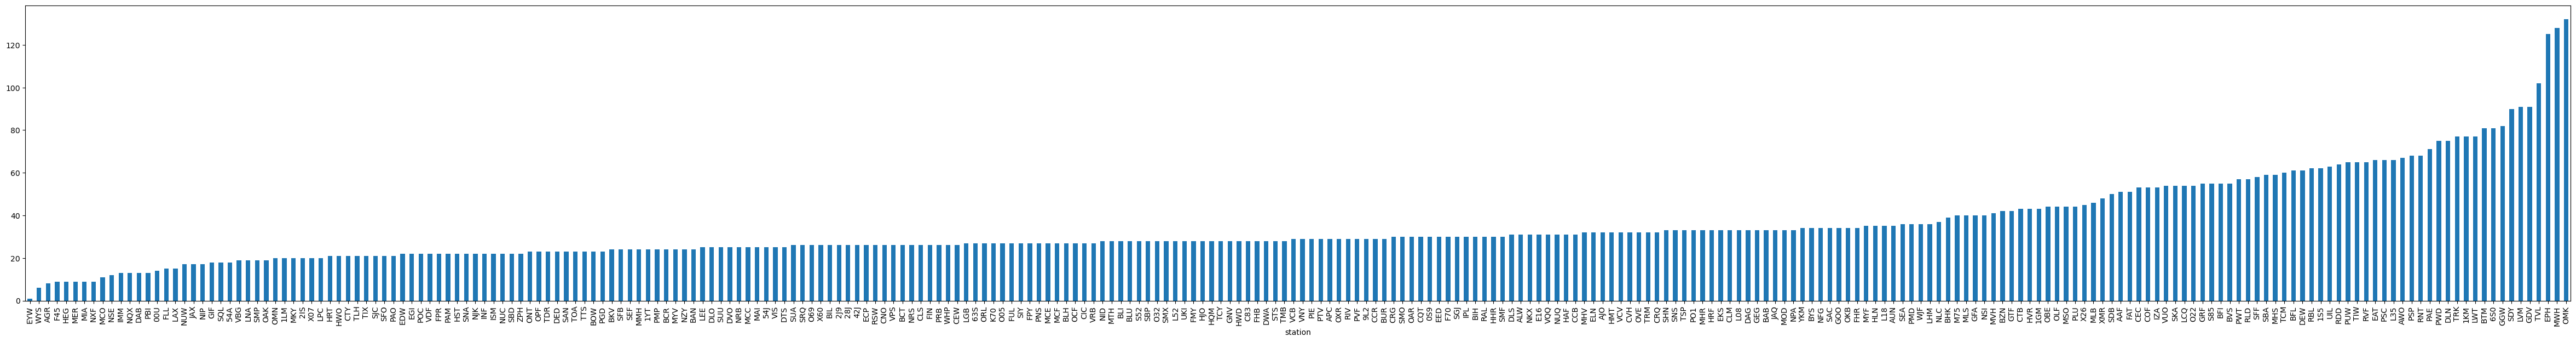

In [81]:
metar_station_counts.plot(kind='bar', figsize=(60,7))

<Axes: ylabel='Frequency'>

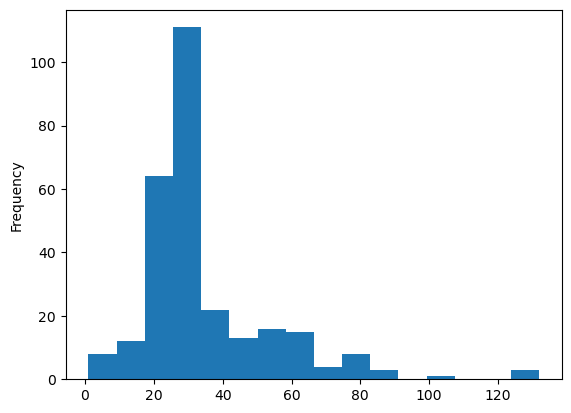

In [82]:
metar_station_counts.plot.hist(bins=16)

In [83]:
station_quantity = metars.reset_index(drop=True).groupby('station')['product_id'].count()
station_quantity

station
00U    14
0S9    30
1GM    43
1KM    77
1LM    20
       ..
X26    45
X60    26
XMR    48
YKM    34
ZPH    22
Name: product_id, Length: 280, dtype: int64

In [84]:
@dataclass
class DatasetUnit:
    stations: Set[str]
    quantity: int

    def __lt__(self, other):
         return (self.quantity, self.stations) < (other.quantity, self.stations)

In [85]:
stations_not_in_cluster = set(remaining_stations_metadata['name']).difference(set.union(*clusters))
print(stations_not_in_cluster)

{'CCR', 'RIV', 'FHR', 'SMP', 'LWT', 'PVF', 'PTV', 'INF', 'NID', 'APC', 'AUN', 'DEW', 'PGD', 'L35', 'PRB', 'MTH', 'BHK', 'MMH', 'HST', 'MHS', '54J', 'HVR', 'SDY', 'CIC', 'SMF', 'TMB', 'C83', 'ZPH', 'O32', 'SHN', 'BKV', '63S', 'S85', 'DED', 'BVS', 'NUW', 'NUC', 'UIL', 'NSI', 'PSP', '54A', 'SFF', 'SAC', 'LHM', 'MOD', 'DLS', 'PUW', '6S0', '0S9', 'F45', 'SIY', 'SGJ', 'FUL', 'TLH', 'WYS', 'RDD', 'SMX', 'M75', 'PWD', 'AWO', 'E16', 'SUA', 'UKI', 'F70', 'RBL', 'FPR', 'TRM', 'LVM', 'DLN', 'IZA', 'OCF', 'S52', 'FPY', 'ALW', 'SBA', 'BZN', 'NSE', 'BLU', 'IMM', 'DLO', 'SBD', '1S5', 'BAN', 'ECP', 'STS', '1KM', 'DAG', 'SRQ', 'JAX', 'HJO', 'MSO', 'VUO', 'BLI', 'O22', 'MKY', 'TVL', 'L52', 'SFB', 'CEC', 'TRK', 'OLF', 'CTY', 'LGB', 'VCV', 'BCR', 'PAE', 'X07', 'SBP', 'BTM', 'EAT', 'XMR', 'FIN', '2J9', 'EED', 'HMT', 'JAQ', 'LCQ', 'AAF', 'VRB', 'OXR', 'NLC', 'PO1', 'GDV', 'HRF', 'CLM', 'RVF', '28J', '1LM', 'HQM', 'SNA', 'VIS', 'GNV', 'PWT', 'MVH', 'FHB', '2IS', 'BYS', 'BIL', 'O05', 'MLS', 'VDF', 'TSP', 'K70'

In [86]:
station_quantity

station
00U    14
0S9    30
1GM    43
1KM    77
1LM    20
       ..
X26    45
X60    26
XMR    48
YKM    34
ZPH    22
Name: product_id, Length: 280, dtype: int64

In [87]:
dataset_units: List[DatasetUnit] = []
for cluster in clusters:
    dataset_units += [DatasetUnit(cluster, sum([station_quantity.loc[station] for station in cluster]))]
dataset_units += [DatasetUnit(set([station]), station_quantity.loc[station]) for station in stations_not_in_cluster]
print(dataset_units)

[DatasetUnit(stations={'YKM', '1YT'}, quantity=58), DatasetUnit(stations={'9L2', 'EDW'}, quantity=51), DatasetUnit(stations={'CNO', 'RAL', 'CCB', 'AJO', 'POC', 'ONT'}, quantity=164), DatasetUnit(stations={'BAB', 'MYV'}, quantity=57), DatasetUnit(stations={'BCT', 'PMP'}, quantity=50), DatasetUnit(stations={'RNT', 'SEA', 'BFI'}, quantity=159), DatasetUnit(stations={'GIF', 'BOW'}, quantity=41), DatasetUnit(stations={'WHP', 'BUR', 'VNY'}, quantity=84), DatasetUnit(stations={'EGI', 'CEW'}, quantity=48), DatasetUnit(stations={'COF', 'MLB'}, quantity=99), DatasetUnit(stations={'SMO', 'CQT', 'HHR', 'TOA', 'LAX'}, quantity=128), DatasetUnit(stations={'NRB', 'HEG', 'NIP', 'CRG', 'VQQ'}, quantity=112), DatasetUnit(stations={'NFG', 'CRQ', 'OKB', 'NXF', 'L18'}, quantity=144), DatasetUnit(stations={'OMN', 'DAB'}, quantity=33), DatasetUnit(stations={'VPS', 'HRT', 'DTS'}, quantity=72), DatasetUnit(stations={'O69', 'DVO'}, quantity=51), DatasetUnit(stations={'EPH', 'MWH'}, quantity=253), DatasetUnit(st

In [88]:
dataset_units_per_state: Dict[str, List[DatasetUnit]] = {}
for state in target_states:
    dataset_units_per_state[state] = list(filter(lambda x: station_metadata.loc[list(x.stations)[0], 'state'] == state, dataset_units))
print(dataset_units_per_state)

{'California': [DatasetUnit(stations={'9L2', 'EDW'}, quantity=51), DatasetUnit(stations={'CNO', 'RAL', 'CCB', 'AJO', 'POC', 'ONT'}, quantity=164), DatasetUnit(stations={'BAB', 'MYV'}, quantity=57), DatasetUnit(stations={'WHP', 'BUR', 'VNY'}, quantity=84), DatasetUnit(stations={'SMO', 'CQT', 'HHR', 'TOA', 'LAX'}, quantity=128), DatasetUnit(stations={'NFG', 'CRQ', 'OKB', 'NXF', 'L18'}, quantity=144), DatasetUnit(stations={'O69', 'DVO'}, quantity=51), DatasetUnit(stations={'SFO', 'SQL', 'HAF', 'NUQ', 'PAO', 'OAK', 'SJC', 'HWD'}, quantity=190), DatasetUnit(stations={'NJK', 'IPL'}, quantity=52), DatasetUnit(stations={'VBG', 'LPC'}, quantity=39), DatasetUnit(stations={'MHR', 'MCC'}, quantity=58), DatasetUnit(stations={'MER', 'MCE'}, quantity=36), DatasetUnit(stations={'NZY', 'MYF', 'NKX', 'NRS', 'SAN'}, quantity=139), DatasetUnit(stations={'OAR', 'SNS'}, quantity=63), DatasetUnit(stations={'WJF', 'PMD'}, quantity=72), DatasetUnit(stations={'SUU', 'VCB'}, quantity=54), DatasetUnit(stations={'

Text(0.5, 0, 'Average number of METARS per satellite image')

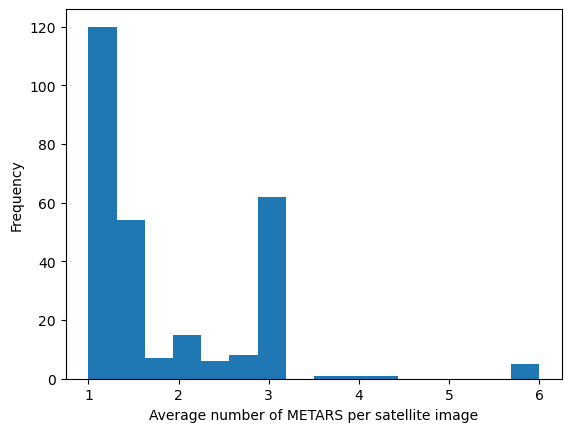

In [89]:
ax: plt.Axes = available_metars.groupby(['station', 'product_id'])['datetime'].count().groupby('station').mean().plot.hist(bins=16)
ax.set_xlabel('Average number of METARS per satellite image')

Text(0.5, 0, 'quantity of METARs')

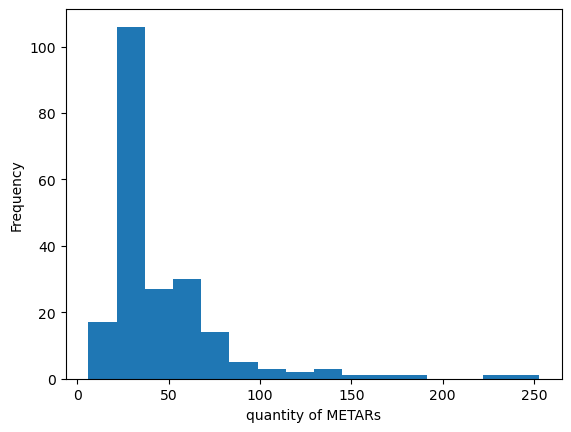

In [90]:
ax: plt.Axes = pd.DataFrame(dataset_units).plot.hist(bins=16, legend=False)
ax.set_xlabel('quantity of METARs')

In [91]:
total_quantity = sum([entry.quantity for entry in dataset_units])
print(f'In total, {total_quantity} units of data are to be distributed for the dataset')

quantity_per_state: Dict[str, int] = {}
for state in target_states:
    quantity_per_state[state] = sum([entry.quantity for entry in dataset_units_per_state[state]])
    print(f'{state} has {quantity_per_state[state]} units of data')

In total, 9728 units of data are to be distributed for the dataset
California has 3881 units of data
Montana has 1641 units of data
Washington has 2112 units of data
Florida has 2094 units of data


In [92]:
@dataclass
class DatasetSplit:
    training: float
    validation: float
    test: float

    def __init__(self, training: float, validation: float, test: float) -> None:
        if not math.isclose(training + validation + test, 1.0):
            raise ValueError('DatasetSplit must sum to 1.0 (100 %)')
        self.training = training
        self.validation = validation
        self.test = test
    
    def getAbsoluteNumbers(self, total_quantity:int) -> Tuple[int, int, int]:
        test_abs        = int(math.ceil(total_quantity * self.test))
        validation_abs  = int(math.ceil(total_quantity * self.validation))
        training_abs    = total_quantity - test_abs - validation_abs
        return (training_abs, validation_abs, test_abs)

In [93]:
dataset_split = DatasetSplit(0.80, 0.10, 0.10)
num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
print(f'DatasetSplit target:'
      f'\nTraining:\t{num_training}\t[{dataset_split.training * 100.0:.2f} %]'
      f'\nValidation:\t{num_validation}\t[{dataset_split.validation * 100.0:.2f} %]'
      f'\nTest:\t\t{num_test}\t[{dataset_split.test * 100.0:.2f} %]')

DatasetSplit target:
Training:	7782	[80.00 %]
Validation:	973	[10.00 %]
Test:		973	[10.00 %]


In [94]:
for state in target_states:
    dataset_units_per_state[state].sort(reverse=True)

In [95]:
@dataclass
class Dataset:
    data: List[DatasetUnit]
    current_size: int
    target_size: int

    def add(self, unit:DatasetUnit):
        self.data += [unit]
        self.current_size += unit.quantity

    def get_missing_quantity(self) -> int:
        return self.target_size - self.current_size
    
    def get_stations(self) -> Set[str]:
        return set.union(*[x.stations for x in self.data])
    
    @staticmethod
    def merge(a, b):
        return Dataset(a.data + b.data, a.current_size + b.current_size, a.target_size + b.target_size)

In [96]:
def greedy_partition(split:DatasetSplit, total_quantity:int, data:List[DatasetUnit]):
    num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
    training    = Dataset([], 0, num_training)
    validation  = Dataset([], 0, num_validation)
    test        = Dataset([], 0, num_test)
    for unit in data:
        # Get the dataset that is missing the most data
        next_dataset = max([
            (training.get_missing_quantity(),      training),
            (validation.get_missing_quantity(),  validation),
            (test.get_missing_quantity(),              test)
        ], key=lambda x: x[0])[1]
        next_dataset.add(unit)
    return (training, validation, test)

In [97]:
training    : Optional[Dataset] = None
validation  : Optional[Dataset] = None
test        : Optional[Dataset] = None
for state in target_states:
      training_subset, validation_subset, test_subset = \
            greedy_partition(dataset_split, quantity_per_state[state], dataset_units_per_state[state])
      if training is None:
            training = training_subset
      else:
            training = Dataset.merge(training, training_subset)
      if validation is None:
            validation = validation_subset
      else:
            validation = Dataset.merge(validation, validation_subset)
      if test is None:
            test = test_subset
      else:
            test = Dataset.merge(test, test_subset)
print(f'DatasetSplit:'
      f'\nTraining:\t{training.current_size}\t[{float(training.current_size) / float(total_quantity) * 100.0:.2f} %]'
      f'\nValidation:\t{validation.current_size}\t[{float(validation.current_size) / float(total_quantity) * 100.0:.2f} %]'
      f'\nTest:\t\t{test.current_size}\t[{float(test.current_size) / float(total_quantity) * 100.0:.2f} %]')

DatasetSplit:
Training:	7771	[79.88 %]
Validation:	976	[10.03 %]
Test:		981	[10.08 %]


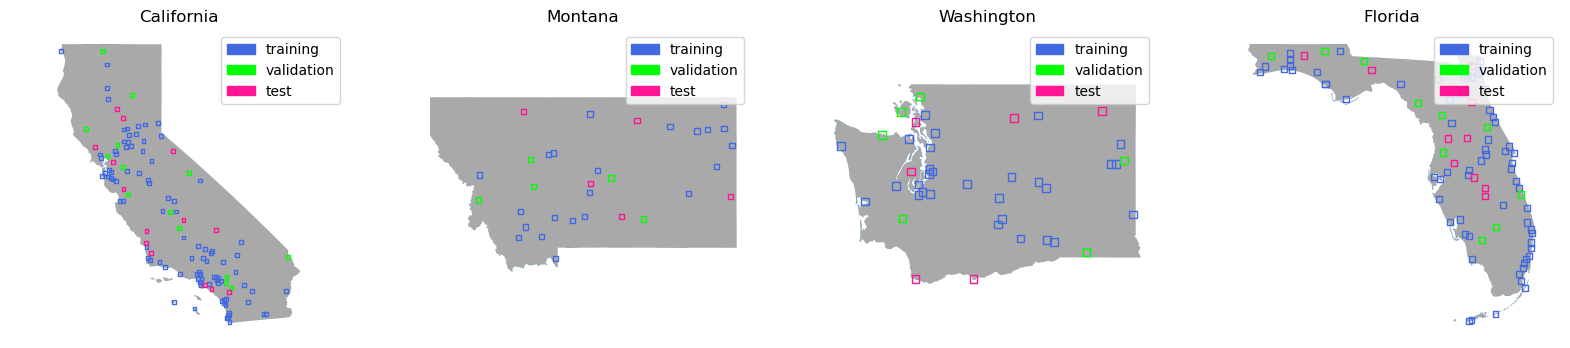

In [98]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(figsize=(20, 4), ncols=len(target_states))
for i, state in enumerate(target_states):
    ax: plt.Axes = axs[i]
    ax.set_aspect('equal', 'datalim')
    ax.set_title(state)
    ax.axis(False)
    plot_state(ax, state, 'darkgray')

    color_training = 'royalblue'
    color_validation = 'lime'
    color_test = 'deeppink'

    patch_training = mpatches.Patch(color=color_training, label='training')
    patch_validation = mpatches.Patch(color=color_validation, label='validation')
    patch_test = mpatches.Patch(color=color_test, label='test')

    selected_stations_metadata = remaining_stations_metadata.loc[list(training.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_training, legend=True
    )

    selected_stations_metadata = remaining_stations_metadata.loc[list(validation.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_validation, legend=True
    )

    selected_stations_metadata = remaining_stations_metadata.loc[list(test.get_stations())]
    selected_stations_metadata = selected_stations_metadata[selected_stations_metadata['state'] == state]
    selected_stations_metadata.plot(
        ax=ax, facecolor='none', edgecolor=color_test, legend=True
    )

    ax.legend(handles=[patch_training, patch_validation, patch_test])

In [99]:
os.makedirs(dataset_dir, exist_ok=True)
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
os.makedirs(training_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [100]:
print(training.get_stations())

{'IPL', 'DAB', 'CEW', 'SMP', 'AJO', 'LWT', 'SKA', 'OPF', 'BAB', 'NIP', 'PVF', 'NKX', 'NRS', 'RAL', 'SAN', 'MIA', 'AUN', 'DEW', 'PGD', 'L35', 'MTH', 'YKM', 'HST', 'WJF', 'MER', 'MHS', 'TIW', 'HVR', 'SDY', 'VNY', 'SMF', 'MHR', 'TMB', 'O32', 'BUR', 'SHN', 'CRQ', 'SMO', '1YT', 'S85', 'MWH', 'BVS', 'NUC', 'UIL', 'NUQ', 'NSI', 'PSP', '54A', 'SAC', 'LHM', 'MOD', 'FMY', 'GEG', 'MCC', 'LPC', 'PUW', 'DTS', 'ORL', 'TDR', '6S0', 'PBI', '0S9', 'COF', 'F45', 'CRG', 'FUL', 'SGJ', 'SUU', 'WYS', 'RDD', 'PAM', 'PNS', 'PWD', 'AWO', 'HEG', 'SUA', 'NQX', 'DVO', 'TTS', 'L18', 'RBL', 'EDW', 'WHP', 'CNO', 'IZA', '9L2', 'TRM', 'LVM', 'DLN', 'MLB', 'OCF', 'NZY', 'SBA', 'FPY', 'SJC', 'BZN', 'BLU', 'RNT', 'ONT', 'BCT', 'NFG', 'VCB', '1S5', 'HHR', 'ISM', 'SEA', 'ECP', 'TCM', 'LAX', 'HAF', 'DAG', '1KM', 'CQT', 'NPA', 'RSW', 'SRQ', 'PMD', 'MSO', 'OKB', 'EPH', 'O22', 'TVL', 'FLL', 'MKY', 'L52', 'SQL', 'SFB', 'CEC', 'PSC', 'MYF', 'TRK', 'OLF', 'MCO', 'HRT', 'EGI', 'SNS', 'VCV', 'PMP', 'GRF', 'LNA', 'GFA', 'PAE', 'BTM'

In [101]:
all_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
all_band_resolutions_meters = [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20]
bands_metadata = pd.DataFrame([all_bands, all_band_resolutions_meters]).T
bands_metadata.columns = ['band', 'resolution [m]']
bands_metadata.set_index('band', inplace=True)
bands_metadata

,resolution [m]
band,
B1,60
B2,10
B3,10
B4,10
B5,20
B6,20
B7,20
B8,10
B8A,20


In [102]:
bands_subset = ['B4', 'B3', 'B2']
assert pd.Series(bands_subset).isin(bands_metadata.index).all(), 'Some bands are invalid!'

In [103]:
def get_features_img_paths(station:str, product_id:str, bands:List[str]) -> Dict[str, str]:
    features_dir = state_dirs.loc[station_metadata.loc[station, 'state'], 'features']
    return {band: os.path.join(features_dir, product_id, band, f'{station}.jp2') for band in bands}

def get_dataset_path(target_dir:str, station:str, product_id:str) -> str:
    return os.path.join(target_dir, station, f'{product_id}.tif')

def map_files_to_dataset_paths(dataset:Dataset, target_dir:str) -> List[Tuple[Dict[str, str], str]]:
    data_subset = metars[(metars['station'].isin(dataset.get_stations()))\
                                   & (metars['max cloud cover'].isin(cloud_covers_order))]
    return data_subset.apply(
        lambda x: (get_features_img_paths(x.station, x.product_id, bands_subset),
                   get_dataset_path(target_dir, x.station, x.product_id)), axis=1)

In [104]:
dataset_file_mappings = [mapping for sublist in [
    map_files_to_dataset_paths(training, training_dir),
    map_files_to_dataset_paths(validation, validation_dir),
    map_files_to_dataset_paths(test, test_dir)
] for mapping in sublist]

In [105]:
dataset_file_mappings

[({'B4': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B4\\COF.jp2',
   'B3': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B3\\COF.jp2',
   'B2': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B2\\COF.jp2'},
  'data\\dataset_unambiuous_cc\\training\\COF\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9.tif'),
 ({'B4': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B4\\MLB.jp2',
   'B3': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B3\\MLB.jp2',
   'B2': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B2\\MLB.jp2'},
  'data\\dataset_unambiuous_cc\\training\\MLB\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9.tif'),
 ({'B4': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B4\\TIX.jp2',
   'B3': 'data\\queries\\Florida\\features\\0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9\\B3\\TIX.jp2',
   'B2': 'data\\queries\\Florida\\features\\0002

In [106]:
from rasterio.enums import Resampling

def transform_image(paths_from:Dict[str, str], img_size:int):
    # Load and rescale images, then convert to numpy
    images: Dict[str, np.ndarray] = {}
    for band, path in paths_from.items():
        image: rasterio.DatasetReader = rasterio.open(path)
        image_array = image.read(1, out_shape=(img_size, img_size), resampling=Resampling.cubic).astype(np.float32) / 10000
        profile = image.profile
        image.close()
        images[band] = image_array
    
    # Run calculations on base image-bands
    images_combined: Dict[str, np.ndarray] = {}
    images_combined['R'] = images['B4']
    images_combined['G'] = images['B3']
    images_combined['B'] = images['B2']

    # Stack images into final image
    image_tensors_stacked = np.stack(list(images_combined.values()), axis=0)
    profile['count'] = image_tensors_stacked.shape[0]
    profile['transform'] = profile['transform'] * profile['transform'].scale(
        (profile['width'] / image_tensors_stacked.shape[2]),
        (profile['height'] / image_tensors_stacked.shape[1])
    )
    profile['height'] = image_tensors_stacked.shape[1]
    profile['width'] = image_tensors_stacked.shape[2]
    profile['dtype'] = image_tensors_stacked.dtype
    profile.pop('tiled')
    profile.pop('blockxsize')
    profile.pop('blockysize')
    profile['driver'] = 'GTiff'
    return image_tensors_stacked, profile

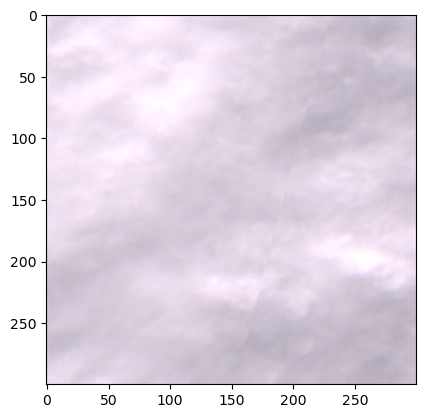

<Axes: >

In [107]:
plot.show(transform_image(dataset_file_mappings[96][0], 300)[0])

In [108]:
image_size = 300 # Image side length in pixels

In [109]:
for paths_from, path_to in tqdm(dataset_file_mappings):
    os.makedirs(os.path.dirname(path_to), exist_ok=True)
    if not os.path.exists(path_to):
        image_out, profile_out = transform_image(paths_from, image_size)
        with rasterio.open(path_to, 'w', **profile_out) as dst:
            dst.write(image_out)

100%|██████████| 9728/9728 [06:25<00:00, 25.24it/s]


In [110]:
def create_dataset_labels(dataset:Dataset):
    labels = metars.reset_index(drop=True)
    labels = labels[labels['station'].isin(dataset.get_stations())\
                              & (labels['max cloud cover'].isin(cloud_covers_order))].copy()
    labels['timedelta [minutes]'] = labels['timedelta'].map(lambda x: x.total_seconds() / 60.0)
    labels = labels[['max cloud cover', 'temperature [C]', 'timedelta [minutes]', 'station', 'product_id']]
    return labels.groupby(['product_id', 'station'], group_keys=True).apply(lambda x: get_newest_label(x))

In [111]:
training_labels = create_dataset_labels(training)
validation_labels = create_dataset_labels(validation)
test_labels = create_dataset_labels(test)

<Axes: title={'center': 'Test'}, ylabel='Frequency'>

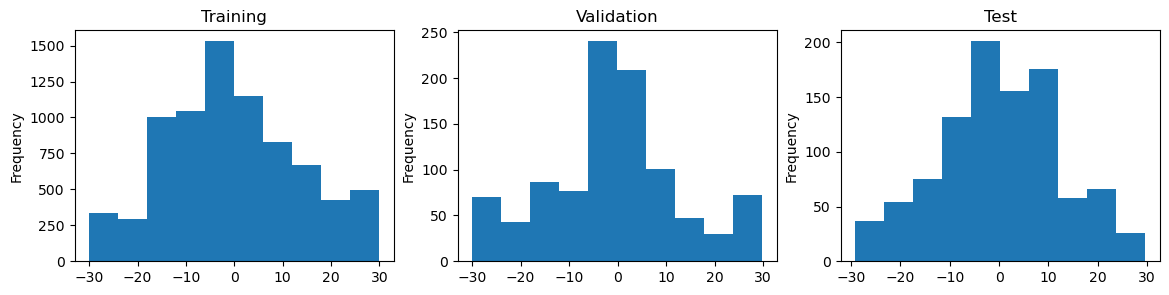

In [112]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[0], title='Training')
validation_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[1], title='Validation')
test_labels['timedelta [minutes]'].plot(kind='hist', ax=axs[2], title='Test')

In [113]:
def print_time_dist(data:pd.DataFrame, name:str):
    series = data['timedelta [minutes]']
    print(f'{name}\tmean offset: {series.mean():.1f} minutes,\tvariance: {series.var():.1f}')

print_time_dist(training_labels, 'Training')
print_time_dist(validation_labels, 'Validation')
print_time_dist(test_labels, 'Test\t')

Training	mean offset: 0.1 minutes,	variance: 187.9
Validation	mean offset: -0.5 minutes,	variance: 190.1
Test		mean offset: 0.2 minutes,	variance: 151.7


In [114]:
training_labels.shape[0]

7771

In [115]:
training_label_counts = pd.Series(dict(Counter(training_labels['max cloud cover'])))
validation_label_counts = pd.Series(dict(Counter(validation_labels['max cloud cover'])))
test_label_counts = pd.Series(dict(Counter(test_labels['max cloud cover'])))

<Axes: title={'center': 'Test'}>

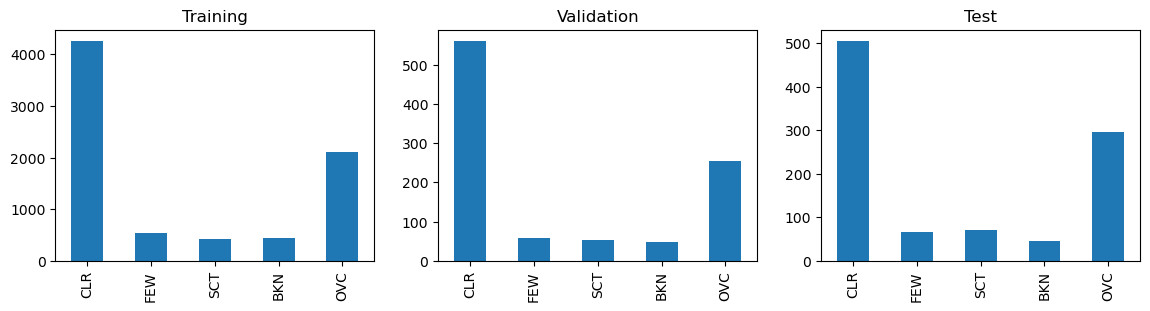

In [116]:
fig, axs = plt.subplots(ncols=3, figsize=(14,3))
training_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[0], title='Training')
validation_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[1], title='Validation')
test_label_counts.loc[cloud_covers_order].plot(kind='bar', ax=axs[2], title='Test')

In [117]:
training_labels.to_csv(os.path.join(dataset_dir, 'training_labels.csv'), index=False)
validation_labels.to_csv(os.path.join(dataset_dir, 'validation_labels.csv'), index=False)
test_labels.to_csv(os.path.join(dataset_dir, 'test_labels.csv'), index=False)

In [118]:
def get_label_weights(label_counts:pd.DataFrame):
    label_weights = pd.DataFrame(label_counts.sum() / label_counts, columns=['weight'])
    # label_weights = pd.DataFrame(label_counts.sum() / pow(label_counts, 1.1), columns=['weight'])
    # label_weights = pd.DataFrame(1.0 - np.sqrt(label_counts / label_counts.sum()), columns=['weight'])
    # label_weights = label_weights / label_weights.sum()
    label_weights.index.set_names('label', inplace=True)
    return label_weights.loc[cloud_covers_order]

training_weights = get_label_weights(training_label_counts)
training_weights

,weight
label,
CLR,1.822467
FEW,14.258716
SCT,18.502381
BKN,17.988426
OVC,3.682938


In [119]:
training_label_counts.loc[cloud_covers_order] * training_weights.loc[cloud_covers_order]['weight']

label
CLR    7771.0
FEW    7771.0
SCT    7771.0
BKN    7771.0
OVC    7771.0
dtype: float64

In [120]:
training_weights.to_csv(os.path.join(dataset_dir, 'training_weights.csv'))

In [121]:
bands_metadata.loc[bands_subset].to_csv(os.path.join(dataset_dir, 'bands_metadata.csv'), index=True)

In [122]:
size = 0
for path, dirs, files in os.walk(dataset_dir):
    for f in files:
        fp = os.path.join(path, f)
        size += os.path.getsize(fp)
byte_size_factor = int(math.floor(int(math.floor(math.log(size, 10))) + 1) / 3)
byte_size_name = 'B'
if byte_size_factor == 1:
    byte_size_name = 'KB'
if byte_size_factor == 2:
    byte_size_name = 'MB'
if byte_size_factor == 3:
    byte_size_name = 'GB'
print(f'Dataset size: {size / math.pow(1000, byte_size_factor):.1f} {byte_size_name}')

Dataset size: 10.5 GB
